# Vanilla 2

This run is a good one, but the structure is bad.

In [1]:
import random
import numpy as np
import seaborn as sns
from dataclasses import dataclass
from enum import IntEnum
from matplotlib import pyplot as plt

In [2]:
rewards = np.full(shape=(6,6), fill_value=-5)
#rewards[0,2] = -20
rewards[1,1] = -20
rewards[2,1] = -20
rewards[3,1] = -20
rewards[4,1] = -20
rewards[5,2] = -20
rewards[1,3] = -20
#rewards[3,3] = -20
rewards[2,4] = -20
rewards[3,5] = -20
rewards[5,5] = -20
rewards[4,4] = 500

print(rewards)


#class Action(IntEnum):
#    UP = 0
#    DOWN = 1
#    LEFT = 2
#    RIGHT = 3

@dataclass
class Transition:
    oldstate: tuple
    newstate: tuple
    reward: int
    action: str
    
    
class EpisodeStats:
    def __init__(self, epoch: int, epsilon: float, start_position: tuple):
        # At start
        self.start_position = start_position
        self.epoch = epoch
        self.epsilon = epsilon
        # At runtime
        self.iterations = 0
        self.path = []
        self.path.append(self.start_position)
        self.steps_taken = np.zeros(shape=(SIZE,SIZE))
        self.steps_taken[start_position[0], start_position[1]] += 1
        self.penalties_given = 0
        self.average_rewards = []
        self.rewards = []
        self.actions = []
        self.end_state = None # Tuple to register endstate
    
    def reached_goal(self, goal: tuple):
        if (self.end_state is not None):
            return goal == self.end_state
        else:
            raise ValueError("Asking for goal reach, but end state is not set")
    
    def add_step(self, transition: Transition, is_penalty: bool):
        self.iterations += 1
        self.path.append(transition.newstate)
        self.steps_taken[transition.newstate[0], transition.newstate[1]] += 1
        self.rewards.append(transition.reward)
        self.average_rewards.append(sum(self.rewards) / self.iterations)
        self.actions.append(transition.action)
        if is_penalty:
            self.penalties_given += 1
    
    def set_end_state(self, end_state: tuple):
        self.end_state = end_state

        
actions = ['up', 'down', 'left', 'right']

SIZE = 6
# PARAMETERS
EPOCHS = 25000
DISCOUNT = 0.9
LEARNING_RATE = 0.1
STATS_EVERY = 500
## Epsilon
epsilon = 0.999
epsilon_start_decaying = 1
epsilon_end_decaying = EPOCHS
epsilon_decay_value = epsilon/(epsilon_end_decaying - epsilon_start_decaying)

MAXITERATIONS = 1000
START = (1,4)
END = (4,4)
ENEMYREWARD = -20
WALLREWARD = -50
FOODREWARD = 500
CHECKPOINTREWARD = 2
CHECKPOINTPENALTY = -2

DEBUG_MODE = True
def step(x: int, y: int, action: str):
    global rewards
    info = {}
    
    # Take action
    if (action == 0):
        next_state = (x-1, y)
    elif (action == 1):
        next_state = (x+1, y)
    elif (action == 2):
        next_state = (x, y-1)
    elif (action == 3):
        next_state = (x, y+1)
    else:
        raise ValueError("Should never happen")
    
    # If state is illegal, return old state
    if (next_state[0] < 0 or next_state[0] > SIZE - 1 or next_state[1] < 0 or next_state[1] > SIZE - 1):
        #print("Invalid step taken: ", (x,y), " - wanted to go to: ",next_state)
        next_state = (x,y)
    reward = rewards[next_state[0], next_state[1]]  
    done = reward == FOODREWARD or reward == ENEMYREWARD
    return next_state, reward, done, info

[[ -5  -5  -5  -5  -5  -5]
 [ -5 -20  -5 -20  -5  -5]
 [ -5 -20  -5  -5 -20  -5]
 [ -5 -20  -5  -5  -5 -20]
 [ -5 -20  -5  -5 500  -5]
 [ -5  -5 -20  -5  -5 -20]]


In [3]:

q_table = np.zeros([SIZE, SIZE, len(actions)])

if (DEBUG_MODE):
    print(f"Q-Table initialized with shape: {q_table.shape}")
    
# Overall stats
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': [], 'epsilon': []}
epoch_overall_stats = []
epochs_ended_for_max_iterations = 0
for epoch in range(EPOCHS):
    # For Stats
    episode_stats = EpisodeStats(epoch=epoch, epsilon=epsilon, start_position=START)
    average_rewards = []

    # Reset variables
    state = START
    reward = 0
    iterations = 0
    is_penalty = False
    done = False
    
    while not done:
        # Choose action
        if random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, len(actions))
        else:
            action = np.argmax(q_table[state[0], state[1]])
        # Take action & register
        newstate, reward, done, _ = step(state[0], state[1], action)
        is_penalty = reward == ENEMYREWARD or reward == WALLREWARD
        
        transition = Transition(oldstate = state, newstate = newstate, reward = reward, action = action)
        episode_stats.add_step(transition, is_penalty)
        
        old_qvalue = q_table[state[0], state[1], action]
        next_max = np.max(q_table[newstate[0], newstate[1]])
        new_value = (1 - LEARNING_RATE) * old_qvalue + LEARNING_RATE * (reward + DISCOUNT * next_max)
        q_table[state[0], state[1], action] = new_value
        
        state = newstate
        if (iterations==MAXITERATIONS):
            epochs_ended_for_max_iterations += 1
            break
        iterations += 1
    
    #### End of epoch
    episode_stats.set_end_state(newstate)
    epoch_overall_stats.append(episode_stats)
    
    if not epoch % STATS_EVERY:
        ep_rewards = [sum(e.rewards) for e in epoch_overall_stats]
        average_reward = sum(ep_rewards[-STATS_EVERY:])/STATS_EVERY
        aggr_ep_rewards['ep'].append(epoch)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
        ## Print
        if DEBUG_MODE:
            reached_goals_count = len([p for p in epoch_overall_stats if END in p.path])
            print(f'Episode: {epoch:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}, reached goals: {reached_goals_count}, max interactions reached: {epochs_ended_for_max_iterations}')
    if epsilon_end_decaying >= epoch >= epsilon_start_decaying:
            epsilon -= epsilon_decay_value

Q-Table initialized with shape: (6, 6, 4)
Episode:     0, average reward: -0.0, current epsilon: 1.00, reached goals: 0, max interactions reached: 0
Episode:   500, average reward: -40.2, current epsilon: 0.98, reached goals: 0, max interactions reached: 0
Episode:  1000, average reward: -40.1, current epsilon: 0.96, reached goals: 1, max interactions reached: 0
Episode:  1500, average reward: -42.8, current epsilon: 0.94, reached goals: 1, max interactions reached: 0
Episode:  2000, average reward: -37.0, current epsilon: 0.92, reached goals: 1, max interactions reached: 0
Episode:  2500, average reward: -35.2, current epsilon: 0.90, reached goals: 2, max interactions reached: 0
Episode:  3000, average reward: -35.7, current epsilon: 0.88, reached goals: 3, max interactions reached: 0
Episode:  3500, average reward: -33.1, current epsilon: 0.86, reached goals: 4, max interactions reached: 0
Episode:  4000, average reward: -33.4, current epsilon: 0.84, reached goals: 5, max interaction

In [4]:
total_iterations = sum(c.iterations for c in epoch_overall_stats)
total_penalties = sum(c.penalties_given for c in epoch_overall_stats)

print(f"== Results after {EPOCHS} epochs ==")
print(f"Total iterations: {total_iterations}")
print(f"Average timesteps per episode: {total_iterations / EPOCHS}")
print(f"Average penalties per episode: {total_penalties / EPOCHS}")

== Results after 25000 epochs ==
Total iterations: 177023
Average timesteps per episode: 7.08092
Average penalties per episode: 0.71276


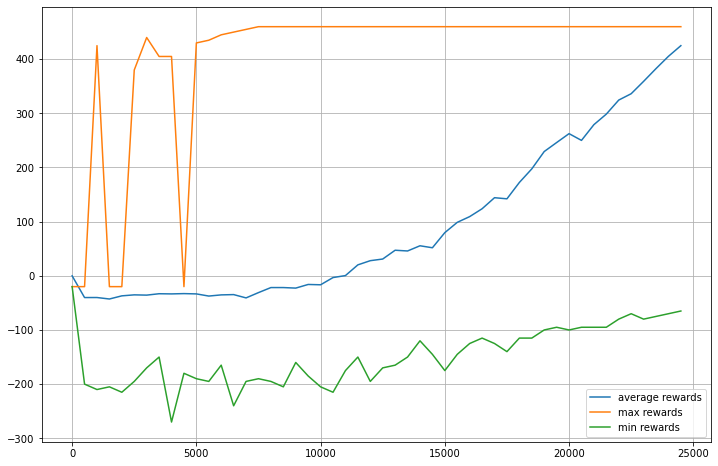

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.grid(True)
plt.show()

In [6]:
print(epoch_overall_stats[-1].__dict__)

{'start_position': (1, 4), 'epoch': 24999, 'epsilon': 3.996159804402922e-05, 'iterations': 9, 'path': [(1, 4), (0, 4), (0, 3), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (4, 3), (4, 4)], 'steps_taken': array([[0., 0., 1., 1., 1., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0.]]), 'penalties_given': 0, 'average_rewards': [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, 51.111111111111114], 'rewards': [-5, -5, -5, -5, -5, -5, -5, -5, 500], 'actions': [0, 2, 2, 1, 1, 1, 1, 3, 3], 'end_state': (4, 4)}


In [7]:
temp = [i for i in range(len(epoch_overall_stats)) if (2,2) in epoch_overall_stats[i].path]
print(temp[:10])

[25, 94, 154, 188, 194, 527, 603, 865, 915, 956]


In [8]:
goodpath_indexes_in_allpaths = [i for i in range(len(epoch_overall_stats)) if (4,4) in epoch_overall_stats[i].path]
goodpaths = [epoch_overall_stats[i].path for i in goodpath_indexes_in_allpaths]
print("Good paths: ", len(goodpaths), " - ", len(goodpath_indexes_in_allpaths))

Good paths:  7181  -  7181
